In [1]:
import time
#Ignore the next statement -- it is just to estimate how long the exercise takes
start = time.perf_counter()

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")

In [3]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, learning_curve, validation_curve, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.inspection import permutation_importance
from tqdm.notebook import tqdm

In [4]:
np.random.seed(903967645)
phishing_dataset = pd.read_csv('../data/phishing_dataset.csv')
print(phishing_dataset.info())
phishing_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   index                        11055 non-null  int64
 1   having_IPhaving_IP_Address   11055 non-null  int64
 2   URLURL_Length                11055 non-null  int64
 3   Shortining_Service           11055 non-null  int64
 4   having_At_Symbol             11055 non-null  int64
 5   double_slash_redirecting     11055 non-null  int64
 6   Prefix_Suffix                11055 non-null  int64
 7   having_Sub_Domain            11055 non-null  int64
 8   SSLfinal_State               11055 non-null  int64
 9   Domain_registeration_length  11055 non-null  int64
 10  Favicon                      11055 non-null  int64
 11  port                         11055 non-null  int64
 12  HTTPS_token                  11055 non-null  int64
 13  Request_URL                  11055 non-null  i

,index,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,2,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,3,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,4,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,5,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [5]:
# Check shape of dataset and for null data
print(phishing_dataset.shape)
phishing_dataset.isna().any().any()

(11055, 32)


False

In [6]:
# Separate features and target
train_X = phishing_dataset.drop(columns=['Result'])
train_y = phishing_dataset['Result']

# Normalize the feature data
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(train_X)

# Convert back to DataFrame
train_X = pd.DataFrame(X_scaled, columns=train_X.columns)

In [7]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train_X, train_y):
    strat_train_set = train_X.iloc[train_index]
    strat_test_set = train_X.iloc[test_index]
    strat_train_labels = train_y.iloc[train_index]
    strat_test_labels = train_y.iloc[test_index]

train_X = strat_train_set
test_X = strat_test_set
train_y = strat_train_labels
test_y = strat_test_labels

In [8]:
%%time
# Initialize and train the neural network
neural_net = MLPClassifier(random_state=42)
neural_net.fit(train_X, train_y)

CPU times: user 1min 5s, sys: 4.05 s, total: 1min 9s
Wall time: 8.01 s


MLPClassifier(random_state=42)

In [9]:
%%time
# Evaluate on training data
train_predictions = neural_net.predict(train_X)
train_accuracy = accuracy_score(train_y, train_predictions)
train_roc_auc = roc_auc_score(train_y, train_predictions)
train_precision = precision_score(train_y, train_predictions)
train_recall = recall_score(train_y, train_predictions)
train_f1 = f1_score(train_y, train_predictions)

print("Training Accuracy:", train_accuracy)
print("Training ROC AUC Score:", train_roc_auc)
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1 Score:", train_f1)
train_report = classification_report(train_y, train_predictions)
print(train_report)

# Write to a text file
with open('../results/phishing-nn/training_metrics_report.txt', 'w') as file:
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Training ROC AUC Score: " + str(train_roc_auc) + "\n")
    file.write("Training Precision: " + str(train_precision) + "\n")
    file.write("Training Recall: " + str(train_recall) + "\n")
    file.write("Training F1 Score: " + str(train_f1) + "\n")
    file.write("\nClassification Report:\n")
    file.write(train_report + "\n")

Training Accuracy: 0.968340117593849
Training ROC AUC Score: 0.9675578345112567
Training Precision: 0.9689140088817118
Training Recall: 0.97442143727162
Training F1 Score: 0.97165991902834
              precision    recall  f1-score   support

          -1       0.97      0.96      0.96      3918
           1       0.97      0.97      0.97      4926

    accuracy                           0.97      8844
   macro avg       0.97      0.97      0.97      8844
weighted avg       0.97      0.97      0.97      8844

CPU times: user 292 ms, sys: 2.22 s, total: 2.51 s
Wall time: 693 ms


In [10]:
%%time
# Evaluate on testing data
test_predictions = neural_net.predict(test_X)
test_accuracy = accuracy_score(test_y, test_predictions)
test_roc_auc = roc_auc_score(test_y, test_predictions)
test_precision = precision_score(test_y, test_predictions)
test_recall = recall_score(test_y, test_predictions)
test_f1 = f1_score(test_y, test_predictions)

print("Testing Accuracy:", test_accuracy)
print("Testing ROC AUC Score:", test_roc_auc)
print("Testing Precision:", test_precision)
print("Testing Recall:", test_recall)
print("Testing F1 Score:", test_f1)
test_report = classification_report(test_y, test_predictions)
print(test_report)

# Write to a text file
with open('../results/phishing-nn/testing_metrics_report.txt', 'w') as file:
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Testing ROC AUC Score: " + str(test_roc_auc) + "\n")
    file.write("Testing Precision: " + str(test_precision) + "\n")
    file.write("Testing Recall: " + str(test_recall) + "\n")
    file.write("Testing F1 Score: " + str(test_f1) + "\n")
    file.write("\nClassification Report:\n")
    file.write(test_report + "\n")

Testing Accuracy: 0.9570330167345092
Testing ROC AUC Score: 0.9553797310963378
Testing Precision: 0.9536741214057508
Testing Recall: 0.9699431356620634
Testing F1 Score: 0.9617398308497785
              precision    recall  f1-score   support

          -1       0.96      0.94      0.95       980
           1       0.95      0.97      0.96      1231

    accuracy                           0.96      2211
   macro avg       0.96      0.96      0.96      2211
weighted avg       0.96      0.96      0.96      2211

CPU times: user 291 ms, sys: 2.09 s, total: 2.38 s
Wall time: 580 ms


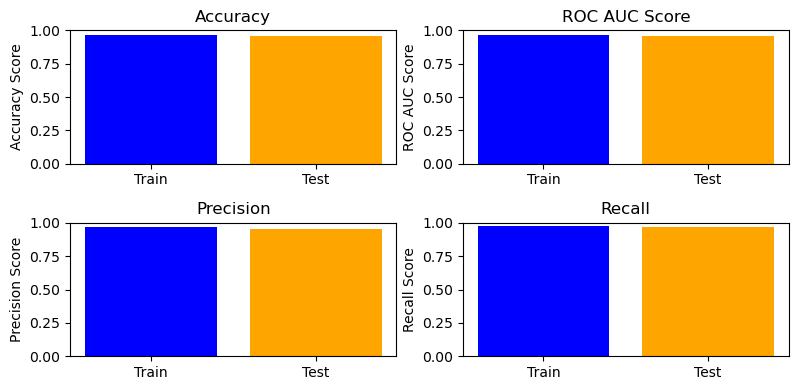

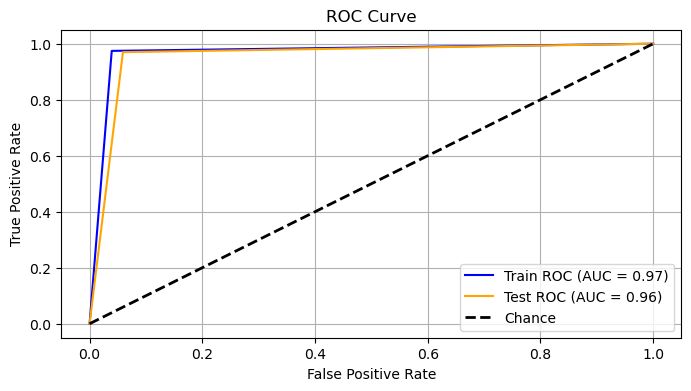

CPU times: user 794 ms, sys: 17.8 ms, total: 811 ms
Wall time: 304 ms


In [11]:
%%time
fig, ax = plt.subplots(2, 2, figsize=(8, 4))

# Accuracy
ax[0, 0].bar(['Train', 'Test'], [train_accuracy, test_accuracy], color=['blue', 'orange'])
ax[0, 0].set_title('Accuracy')
ax[0, 0].set_ylim([0, 1])
ax[0, 0].set_ylabel('Accuracy Score')

# ROC AUC Score
ax[0, 1].bar(['Train', 'Test'], [train_roc_auc, test_roc_auc], color=['blue', 'orange'])
ax[0, 1].set_title('ROC AUC Score')
ax[0, 1].set_ylim([0, 1])
ax[0, 1].set_ylabel('ROC AUC Score')

# Precision
ax[1, 0].bar(['Train', 'Test'], [train_precision, test_precision], color=['blue', 'orange'])
ax[1, 0].set_title('Precision')
ax[1, 0].set_ylim([0, 1])
ax[1, 0].set_ylabel('Precision Score')

# Recall
ax[1, 1].bar(['Train', 'Test'], [train_recall, test_recall], color=['blue', 'orange'])
ax[1, 1].set_title('Recall')
ax[1, 1].set_ylim([0, 1])
ax[1, 1].set_ylabel('Recall Score')

plt.tight_layout()
fig.savefig('../images/phishing-nn/metrics-comparison.png')
plt.show()

# Plotting  ROC Curves
train_fpr, train_tpr, _ = roc_curve(train_y, train_predictions)
test_fpr, test_tpr, _ = roc_curve(test_y, test_predictions)

plt.figure(figsize=(8, 4))
plt.plot(train_fpr, train_tpr, label=f'Train ROC (AUC = {auc(train_fpr, train_tpr):.2f})', color='blue')
plt.plot(test_fpr, test_tpr, label=f'Test ROC (AUC = {auc(test_fpr, test_tpr):.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/phishing-nn/roc-curve-fpr-tpr')
plt.show()

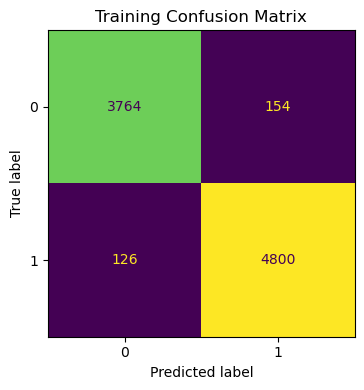

FileNotFoundError: [Errno 2] No such file or directory: '/Users/xavierelon/Library/Mobile Documents/com~apple~CloudDocs/gatech/CS7641/Assignment1/supervised_learning/images/phising-nn/testing-cm.png'

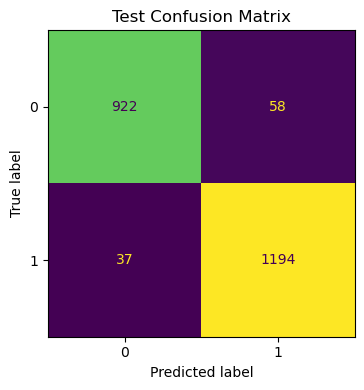

In [12]:
%%time
# Plot and save Training Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
train_cm = confusion_matrix(train_y, train_predictions)
ConfusionMatrixDisplay(train_cm).plot(ax=ax, colorbar=False)
ax.set_title("Training Confusion Matrix")
plt.tight_layout()
plt.savefig('../images/phishing-nn/training-cm.png')
plt.show()

# Plot and save Test Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
test_cm = confusion_matrix(test_y, test_predictions)
ConfusionMatrixDisplay(test_cm).plot(ax=ax, colorbar=False)
ax.set_title('Test Confusion Matrix')
plt.tight_layout()
plt.savefig('../images/phising-nn/testing-cm.png')
plt.show()

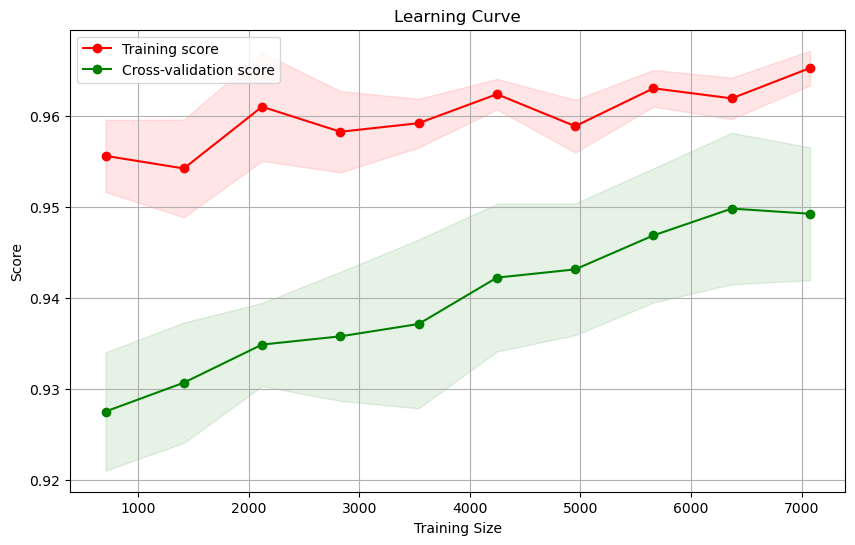

CPU times: user 18min 57s, sys: 50.7 s, total: 19min 48s
Wall time: 2min 7s


In [13]:
%%time
train_sizes, train_scores, test_scores = learning_curve(neural_net, train_X, train_y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label="Cross-validation score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/phishing-nn/roc-curve-fpr-tpr.png')
plt.show()

Training progress:   0%|          | 0/10 [00:00<?, ?it/s]

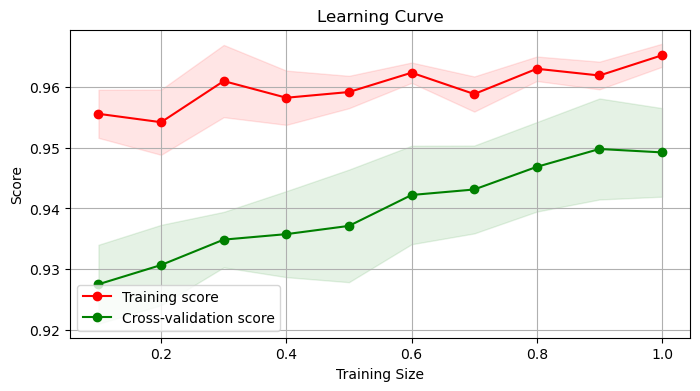

CPU times: user 19min 16s, sys: 1min 7s, total: 20min 23s
Wall time: 2min 12s


In [14]:
%%time
# Create a wrapper function for learning_curve to show progress
def learning_curve_with_progress(estimator, X, y, cv, scoring, train_sizes):
    all_train_scores = []
    all_test_scores = []
    for train_size in tqdm(train_sizes, desc='Training progress'):
        _, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=[train_size], cv=cv, scoring=scoring)
        all_train_scores.append(train_scores)
        all_test_scores.append(test_scores)
    return train_sizes, np.array(all_train_scores).squeeze(), np.array(all_test_scores).squeeze()

train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve_with_progress(neural_net, train_X, train_y, cv=5, scoring='accuracy', train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 4))

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/phishing-nn/learning-curve-training-size.png')
plt.show()

/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum i

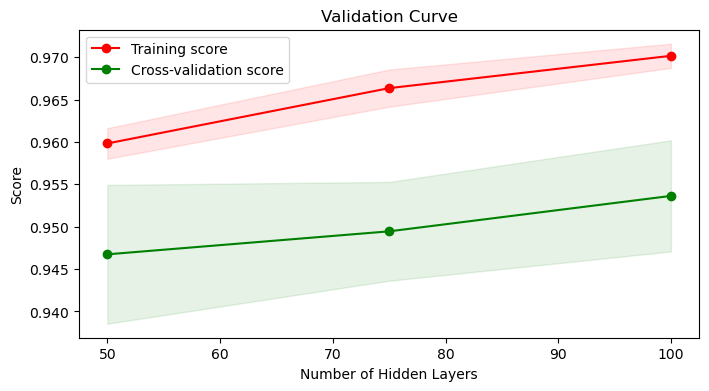

CPU times: user 336 ms, sys: 780 ms, total: 1.12 s
Wall time: 5.08 s


In [15]:
%%time
param_range = [50, 75, 100]
train_scores, test_scores = validation_curve(MLPClassifier(), train_X, train_y, param_name="hidden_layer_sizes", param_range=param_range, cv=5, scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 4))
plt.plot(param_range, train_scores_mean, 'o-', color='r', label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color='g', label="Cross-validation score")

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.title('Validation Curve')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid
plt.savefig('../images/phishing-nn/validation-curve-hidden-layers.png')
plt.show()

/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum i

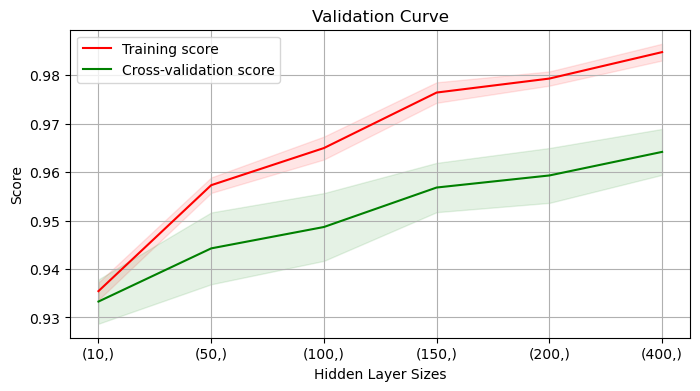

CPU times: user 518 ms, sys: 441 ms, total: 958 ms
Wall time: 14.2 s


In [16]:
%%time
# Define the range for the hyperparameter hidden_layer_sizes
param_range = [(10,), (50,), (100,), (150,), (200,), (400,)]

# Calculate validation curve data
train_scores, test_scores = validation_curve(
    MLPClassifier(random_state=42), train_X, train_y, param_name="hidden_layer_sizes", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(8, 4))
plt.plot([str(x) for x in param_range], train_scores_mean, label="Training score", color="r")
plt.plot([str(x) for x in param_range], test_scores_mean, label="Cross-validation score", color="g")

plt.fill_between([str(x) for x in param_range], train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between([str(x) for x in param_range], test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.title("Validation Curve")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/phishing-nn/validation-curve-hidden-layer-sizes-2.png')
plt.show()

/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum i

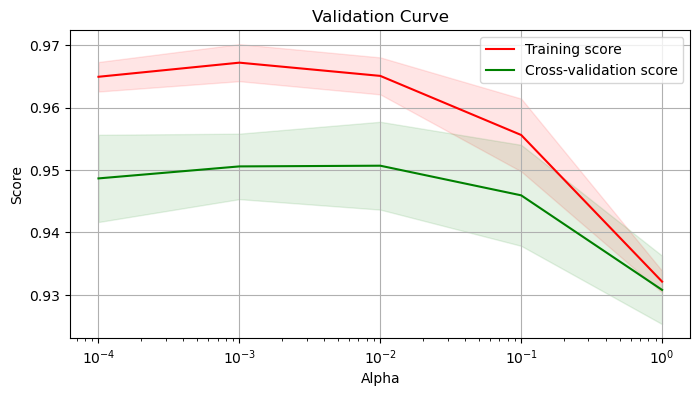

CPU times: user 940 ms, sys: 28.4 ms, total: 968 ms
Wall time: 6.2 s


In [17]:
%%time
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define the range for the hyperparameter alpha
param_range = [0.0001, 0.001, 0.01, 0.1, 1]

# Calculate validation curve data
train_scores, test_scores = validation_curve(
    MLPClassifier(hidden_layer_sizes=(100,), random_state=42), train_X, train_y, param_name="alpha", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(8, 4))
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")

plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.title("Validation Curve")
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.xscale('log')  # Use a logarithmic scale for alpha
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/phishing-nn/validation-curve-alpha.png')
plt.show()

In [18]:
%%time
# Perform 10-fold cross-validation
cv_scores = cross_val_score(neural_net, train_X, train_y, cv=10, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

# Write cross-validation scores to a text file
with open('../results/phishing-nn/cross_validation_scores.txt', 'w') as file:
    file.write("Cross-validation scores: " + np.array2string(cv_scores) + "\n")
    file.write("Mean cross-validation score: " + str(cv_scores.mean()) + "\n")

Cross-validation scores: [0.95028249 0.96497175 0.95254237 0.94576271 0.93325792 0.94343891
 0.95701357 0.95135747 0.95135747 0.95475113]
Mean cross-validation score: 0.9504735792622133
CPU times: user 8min 40s, sys: 24.1 s, total: 9min 4s
Wall time: 59.7 s


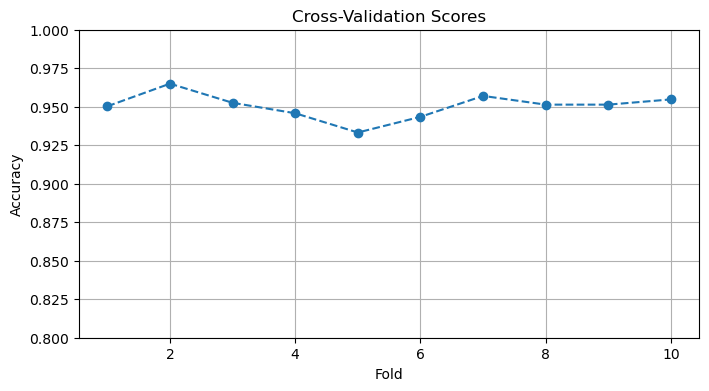

In [19]:
# Plot cross-validation scores
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), cv_scores, marker='o', linestyle='--')
plt.title('Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.grid(True)
plt.savefig('../images/phishing-nn/cross-validation-scores.png')
plt.show()

              precision    recall  f1-score   support

          -1       0.95      0.94      0.94      3918
           1       0.95      0.96      0.96      4926

    accuracy                           0.95      8844
   macro avg       0.95      0.95      0.95      8844
weighted avg       0.95      0.95      0.95      8844



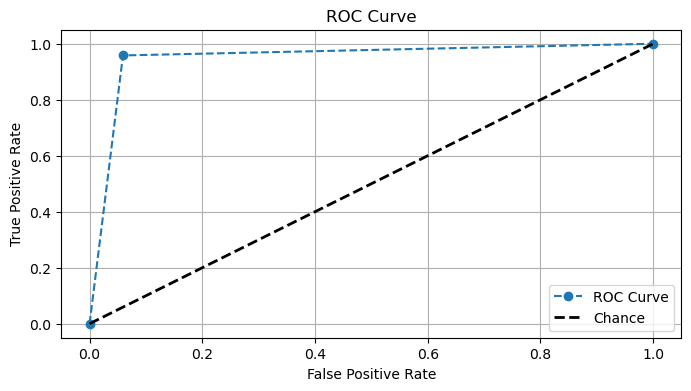

CPU times: user 7min 54s, sys: 26.9 s, total: 8min 21s
Wall time: 55 s


In [20]:
%%time
y_pred = cross_val_predict(neural_net, train_X, train_y, cv=10)

report = classification_report(train_y, y_pred)
print(report)

with open('../results/phishing-nn/classification_report.txt', 'w') as file:
    file.write(report)
    
fpr, tpr, thresholds = roc_curve(train_y, y_pred, pos_label=1)
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, marker='o', linestyle='--', label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/phishing-nn/roc-curve-fpr.png')
plt.show()

In [21]:
%%time
# Suppress the convergence warning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Hyperparameter tuning using GridSearchCV with increased max_iter
param_grid = {
    'hidden_layer_sizes': [(50,), (75,), (100,)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['adaptive'],
    'max_iter': [50, 100, 200],
}

mlp = MLPClassifier()
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(train_X, train_y)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Write the best parameters and best score to a text file
with open('../results/phishing-nn/grid_search_results.txt', 'w') as file:
    file.write("Best parameters found: " + str(grid_search.best_params_) + "\n")
    file.write("Best cross-validation score: " + str(grid_search.best_score_) + "\n")

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/anaconda3/envs/supervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iter

Best parameters found:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 200, 'solver': 'adam'}
Best cross-validation score:  0.9534154071247144
CPU times: user 42.8 s, sys: 4 s, total: 46.8 s
Wall time: 1min


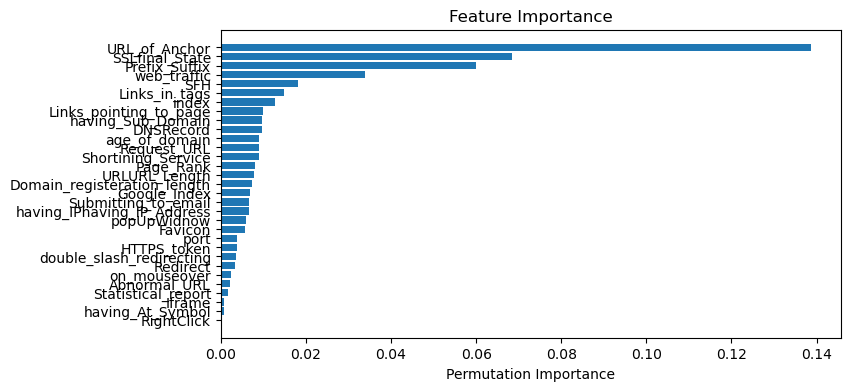

CPU times: user 47.5 s, sys: 3.42 s, total: 50.9 s
Wall time: 5.64 s


In [22]:
%%time
# Fit the model with the best found parameters
best_mlp = grid_search.best_estimator_
best_mlp.fit(train_X, train_y)

# Calculate feature importance
result = permutation_importance(best_mlp, test_X, test_y, n_repeats=10, random_state=42, n_jobs=-1)

# Plot feature importance
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(8, 4))
plt.barh(train_X.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.savefig('../images/phishing-nn/feature-importance.png')
plt.show()

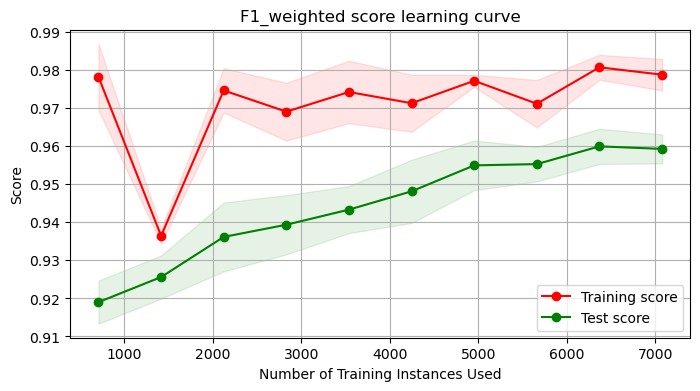

CPU times: user 402 ms, sys: 41.2 ms, total: 443 ms
Wall time: 22.9 s


In [27]:
%%time
best_net = MLPClassifier(activation='tanh', alpha=0.0001, 
              hidden_layer_sizes=(75,), learning_rate='adaptive',
              max_iter=2000, solver='adam')

# Assuming best_mlp, train_X, train_y are already defined
train_sizes, train_scores, test_scores = learning_curve(
    best_net, train_X, train_y, cv=5, scoring='f1_weighted',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 4))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

plt.title('F1_weighted score learning curve')
plt.xlabel('Number of Training Instances Used')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/phishing-nn/best-nn-training-vs-test-set')
plt.show()

# Write to a text file
with open('../results/phishing-nn/test_classification_results.txt', 'w') as file:
    file.write("Classification Report:\n")
    file.write(test_report + "\n")
    file.write("Confusion Matrix:\n")
    file.write(np.array2string(test_cm) + "\n")

In [24]:
end = time.perf_counter()
print("Time taken: in min", (end - start)/60)

Time taken: in min 8.21197472916668
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=50, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=200, solver=adam; total time=   1.9s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(75,), learning_rate=adaptive, max_iter=200, solver=adam; total time=   2.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=200, solver=adam; total time=   2.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(75,), learning_rate=adaptive, max_iter=50, solver=adam; total time=   0.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(75,), learning_rate=adaptive, max_iter=100, solver=adam; total time=   1.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, max_iter=50, solver=adam; total time=   0.7s
[CV] END activat